# Image Fitting and Super-Resolution with LIIF and SIREN

This notebook implements [Local Implicit Image Function (LIIF)](https://arxiv.org/abs/2012.09161) for continuous image representation using a [SIREN](https://arxiv.org/abs/2006.09661) (Sinusoidal Representation Network) for image fitting and super-resolution.

## SIREN Architecture

SIRENs replace standard activation functions (like ReLU) with periodic sine functions that better capture fine details and continuous signals in images:

$$\phi(x) = \sin(\omega_0 x)$$

For a layer $l$: $\Phi_l(x) = \sin(\omega_0 W_l x + b_l)$

## LIIF Approach

LIIF represents images as continuous functions that map coordinates to RGB values. Given a point $(x,y)$, the model predicts the color at that specific location. This allows for:

1. **Arbitrary resolution:** Sample at any coordinates without resolution constraints
2. **Detail preservation:** Maintains fine details better than traditional methods
3. **Smooth interpolation:** No pixelation or blocky artifacts

## Workflow
1. Load an image and create coordinate-pixel pairs
2. Train a SIREN model to map coordinates to pixel values
3. Sample the model at any desired resolution for super-resolution

In [1]:
# from torchsr.datasets import Div2K
# from torchsr.models import ninasr_b0
from utils.training_utils_LIIF import (
    Siren,
    ImageFitting,
    pixel_coordinates_normalized,
    plot_image,
    list_png_files,
    load_image,
    train_siren,
)
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import os
import itertools
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Autoreload
%reload_ext autoreload
%autoreload 2

# Div2K dataset
# dataset = Div2K(root="./data", scale=2, download=False)

In [18]:
# List all PNG files in the data folder
data_folder = "data"
image_files = list_png_files(data_folder)
print(f"Available PNG files: {image_files}")

Available PNG files: ['0010.png', '0028.png', '0002.png']


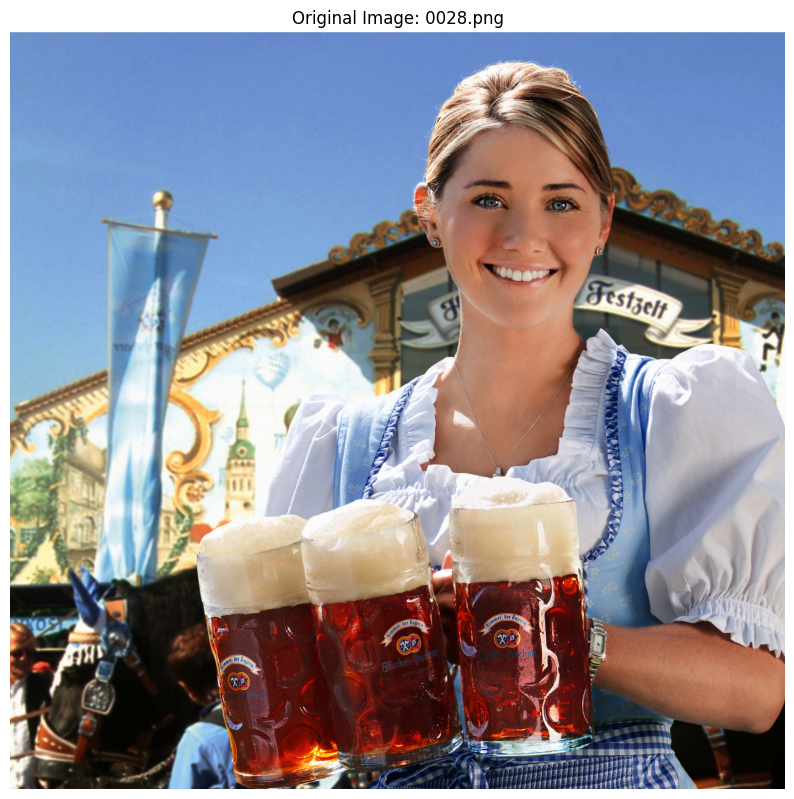

Image dimensions: 1992x2040, 3 channels


In [19]:
img_file_path = image_files[-2]
img_np_original, height_target, width_target, channels = load_image(data_folder, img_file_path)

In [ ]:
# Initialize the model
device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)

print("Currently using device:", device)

Currently using device: mps


In [5]:
# Define the target resolution for the image
H, W = 512, 512  # Adjust as needed

# Create the ImageFitting dataset
dataset = ImageFitting(image_path=os.path.join(data_folder, img_file_path), H=H, W=W)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

/opt/anaconda3/envs/main/lib/python3.10/site-packages/torch/functional.py:540: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# Initialize the Siren model
model = Siren(
    in_features=2,
    hidden_features=256,
    hidden_layers=3,
    out_features=3,
    outermost_linear=True,
    first_omega_0=30,
    hidden_omega_0=30,
)

# Move the model to the appropriate device
model.to(device)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

Step 0, Total loss 0.302525


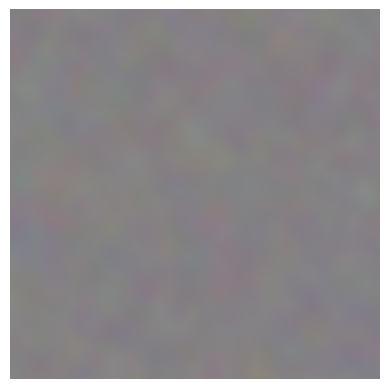

Step 250, Total loss 0.008756


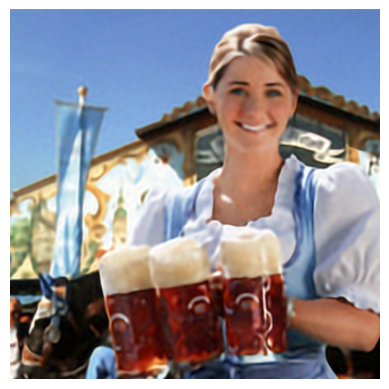

Step 500, Total loss 0.003938


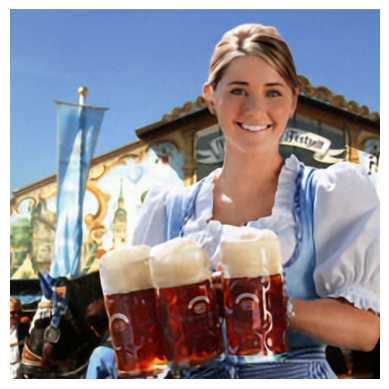

Step 750, Total loss 0.002451


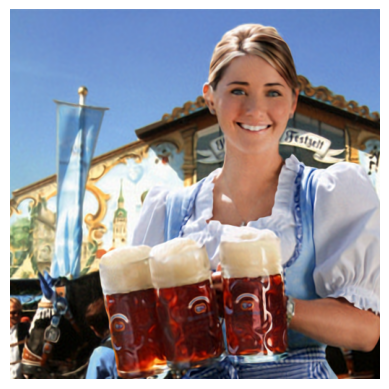

Step 1000, Total loss 0.001641


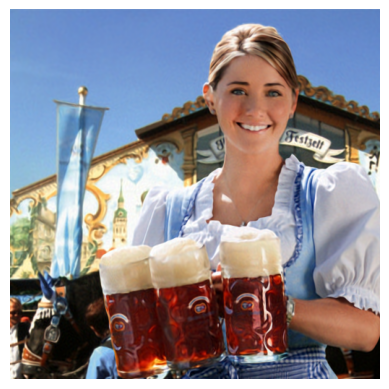

Step 1250, Total loss 0.001239


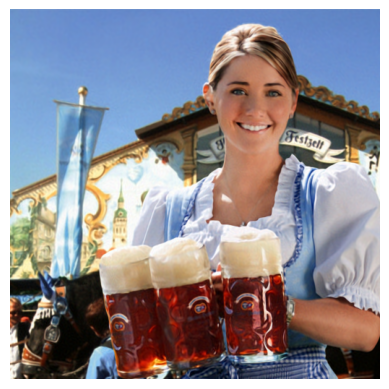

Step 1500, Total loss 0.000990


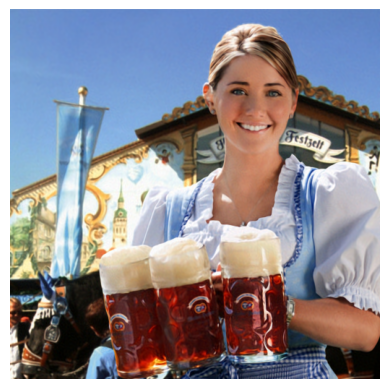

Step 1750, Total loss 0.000864


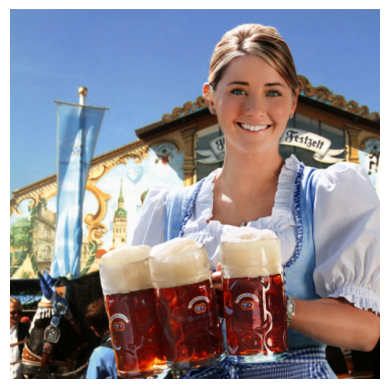

In [7]:
# Train the model
train_siren(
    model=model,
    dataloader=dataloader,
    total_steps=2000,
    steps_til_summary=250,
    lr=1e-4,
    device=device,
    H=H,
    W=W,
)